# Primer análisis básico para definir posibles bases de datos a utilizar

### Cargo paquetes

In [88]:
# Load packages
import sys
sys.path.insert(0, '/datos/julian.giles/Scripts/python')

import matplotlib

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs	
import cartopy.feature 	
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np
from numpy import ma 
import pandas as pd
import xarray as xr
from datetime import datetime
import matplotlib.colors as mcolors
import os
from matplotlib import gridspec
import scipy.stats
from scipy import signal
import gc
import juli_functions
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
from skimage.feature import peak_local_max
import itertools
import math
import timeit
from scipy import stats
import collections
import seaborn as sns

### Cargo datos

In [2]:
# ERA5-Land data
era5land_path = '/datosfreyja/d1/GDATA/ERA5-Land/'
era5land = xr.open_mfdataset(era5land_path+'*/*.nc')

In [3]:
era5land

<xarray.Dataset>
Dimensions:    (latitude: 11, longitude: 11, time: 26304)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-01 ... 2021-12-31T23:00:00
  * longitude  (longitude) float32 -63.0 -62.9 -62.8 -62.7 ... -62.2 -62.1 -62.0
  * latitude   (latitude) float32 -32.0 -32.1 -32.2 -32.3 ... -32.8 -32.9 -33.0
Data variables:
    lai_hv     (time, latitude, longitude) float32 dask.array<chunksize=(8760, 11, 11), meta=np.ndarray>
    lai_lv     (time, latitude, longitude) float32 dask.array<chunksize=(8760, 11, 11), meta=np.ndarray>
    ro         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 11, 11), meta=np.ndarray>
    sp         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 11, 11), meta=np.ndarray>
    sro        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 11, 11), meta=np.ndarray>
    swvl1      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 11, 11), meta=np.ndarray>
    swvl2      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 11, 11), meta=np.ndarray>
    swvl3      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 11, 11), meta=np.ndarray>
    swvl4      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 11, 11), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(17544, 11, 11), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 11, 11), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 11, 11), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-09 06:15:32 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

In [79]:
# Observations
obs_path = '/datos/julian.giles/flash_flood/justiniano_posse/'

justiniano_posse = pd.read_csv(obs_path+'ClimaReporte_omixom_JustinianoPosse.csv', sep=';', low_memory=False, skip_blank_lines=True, parse_dates=['Fecha'], infer_datetime_format=True).dropna(how='all')

dique_aforador = pd.read_csv(obs_path+'Altura_diqueAforador_Estacion-4216.csv', sep=';', low_memory=False, skip_blank_lines=True, header=1, parse_dates=['Fecha y Hora'], infer_datetime_format=True).dropna(how='all')


In [80]:
justiniano_posse

,Fecha,Temperatura [°C],Humedad [%HR],Punto de rocío [°C],Registro de Lluvia [mm],Velocidad de Viento [Km/h],Direccion de Viento [°],Dirección de Viento-(Rosa de los Vientos) [],Rafaga de Viento [km/h],Presion [hPa],Radiacion Solar [w/m2],Temperatura de suelo [°C],Nivel de Napa Freática [cm]
0,2018-08-14 11:20:00,18.1,32.0,NaN,0.0,5.9,67.5,ENE,7.7,978.8,13.0,17.2,17.0
1,2018-08-14 11:30:00,18.1,31.7,NaN,0.0,6.0,67.5,ENE,7.4,978.8,13.0,17.2,17.0
2,2018-08-14 11:40:00,18.1,31.8,NaN,0.0,6.0,67.5,ENE,7.9,977.5,13.0,17.2,17.0
3,2018-08-14 11:50:00,18.1,32.0,NaN,0.0,6.1,67.5,ENE,8.4,977.5,13.0,17.2,17.0
4,2018-08-14 12:00:00,18.1,32.0,NaN,0.0,6.1,67.5,ENE,8.1,977.5,12.0,17.3,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139458,2022-02-08 10:30:00,23.1,64.8,16.1,0.0,9.8,67.5,ENE,20.3,1003.8,677.4,19.6,-261.2
139459,2022-02-08 10:40:00,23.3,64.4,16.2,0.0,10.5,67.5,ENE,20.7,1003.8,705.1,19.7,-261.2
139460,2022-02-08 10:50:00,23.6,65.5,16.8,0.0,9.5,112.5,ESE,21.3,1002.5,728.8,19.7,-261.2
139461,2022-02-08 11:00:00,23.9,64.5,16.8,0.0,10.5,112.5,ESE,23.0,1001.9,752.5,19.8,-261.2


<AxesSubplot:xlabel='Fecha'>

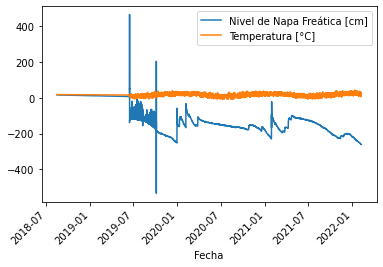

In [81]:
justiniano_posse.plot(x='Fecha', y=['Nivel de Napa Freática [cm]', 'Temperatura [°C]'], rot=45)

In [82]:
dique_aforador

,Fecha y Hora,Altura [m]
0,2019-12-19 13:00:00,0.00
1,2019-12-19 14:00:00,0.00
2,2019-12-19 15:00:00,0.00
3,2019-12-19 16:00:00,0.00
4,2019-12-19 17:00:00,0.00
...,...,...
14778,2022-02-08 15:00:00,1.34
14779,2022-02-08 16:00:00,1.34
14780,2022-02-08 17:00:00,1.33
14781,2022-02-08 18:00:00,1.33


<AxesSubplot:xlabel='Fecha y Hora'>

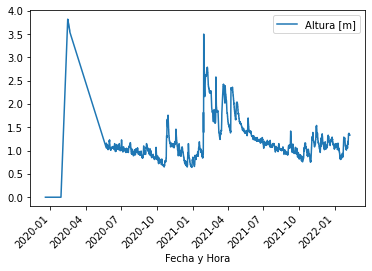

In [83]:
dique_aforador.plot(x='Fecha y Hora', rot=45)


#### Busco arrancar desde donde los datos parecen más decentes, veamos junio 2020

<AxesSubplot:xlabel='Fecha'>

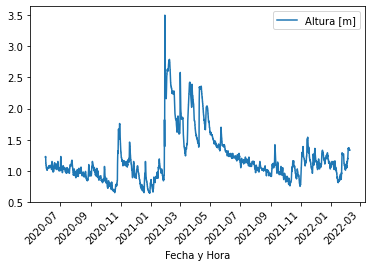

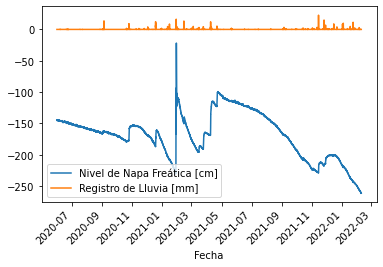

In [105]:
dique_aforador_short = dique_aforador.loc[dique_aforador['Fecha y Hora']>'2020-06-01 00:00:00']
justiniano_posse_short = justiniano_posse.loc[justiniano_posse['Fecha']>'2020-06-01 00:00:00']


dique_aforador_short.plot(x='Fecha y Hora', rot=45)
justiniano_posse_short.plot(x='Fecha', y=['Nivel de Napa Freática [cm]', 'Registro de Lluvia [mm]'], rot=45)

#### Comparemos algunas variables entre datasets

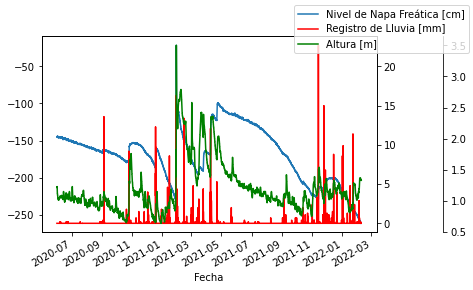

In [113]:
# datos de estaciones
ax = justiniano_posse_short.plot(x="Fecha", y="Nivel de Napa Freática [cm]", legend=False)
ax2 = ax.twinx()
justiniano_posse_short.plot(x="Fecha", y="Registro de Lluvia [mm]", ax=ax2, legend=False, color="r")
ax3 = ax.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
dique_aforador_short.plot(x="Fecha y Hora", y="Altura [m]", ax=ax3, legend=False, color="g")


ax.figure.legend()
plt.show()

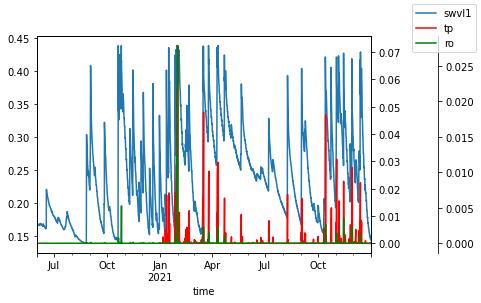

In [125]:
# datos de ERA5
era5land_loc = era5land.loc[{'latitude':-32.9, 'longitude': -62.6, 'time': slice('2020-06-01', '2021-12-31')}].to_dataframe()

ax = era5land_loc['swvl1'].plot(legend=False)
ax2 = ax.twinx()
era5land_loc['tp'].plot(ax=ax2, legend=False, color="r")
ax3 = ax.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
era5land_loc['ro'].plot(ax=ax3, legend=False, color="g")


ax.figure.legend()
plt.show()

In [48]:
dique_aforador_xr = xr.Dataset.from_dataframe(dique_aforador)

In [49]:
dique_aforador_xr

<xarray.Dataset>
Dimensions:       (index: 14783)
Coordinates:
  * index         (index) int64 0 1 2 3 4 5 ... 14778 14779 14780 14781 14782
Data variables:
    Fecha y Hora  (index) object '19/12/2019 13:00' ... '08/02/2022 19:00'
    Altura [m]    (index) float64 0.0 0.0 0.0 0.0 0.0 ... 1.34 1.33 1.33 1.33